# Ej1: Clasificación de rostros: ViT

In [ ]:
# Cabrones ya no quiero hacer tarea me lleva

# Ej2: Reconocimiento de comandos de voz

La importación de datos se hace basándonos en el notebook oficial del curso [(Github de Gibrán)](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2026-1/notebooks/1d_procesamiento_audio.ipynb). La red ya es una implementación personal.

## 2.1 Datos, Dataset, y Dataloader

In [1]:
import random
import librosa
import IPython as ip
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from tqdm.auto import trange
import collections

In [2]:
speech_ds = SPEECHCOMMANDS(r'C:\Users\FLopezP\Desktop\PCIC\Tercer Semestre\Datasets', download = False) # download = True solo si no lo predescargaste

In [3]:
CLASSES = (
    'backward', 'bed', 'bird', 'cat', 'dog',
    'down', 'eight', 'five', 'follow', 'forward',
    'four', 'go', 'happy', 'house', 'learn',
    'left', 'marvin', 'nine', 'no', 'off',
    'on', 'one', 'right', 'seven', 'sheila',
    'six', 'stop', 'three', 'tree', 'two',
    'up', 'visual', 'wow', 'yes', 'zero'
)

NUM_CLASSES = len(CLASSES)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}
print(CLASS_IDX)

{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}


In [4]:
# Parámetros. (Extraídos del notebook)
BATCH_SIZE = 32
SECS = 1
SAMPLE_RATE = 16000
N_FFT = 400
HOP_LENGTH = N_FFT // 2

class MySpeechCommands(SPEECHCOMMANDS):
    """
    Clase para crear el dataloader. (Extraída del notebook)
    """
    def __init__(self, 
               root, 
               download = False, 
               subset = None,
               waveform_tsfm = None, 
               label_tsfm = None):
        super().__init__(root = root, download = download, subset = subset)
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm
    
    def __getitem__(self, i):
        waveform, sample_rate, label, *_ = super().__getitem__(i)
    
        if self.waveform_tsfm:
            x = self.waveform_tsfm(waveform)
        
        if self.label_tsfm:
            y = self.label_tsfm(label)
          
        return x, y, label, sample_rate
      
class WaveformPadTruncate(nn.Module):
    """
    Clase para crear el dataloader. (Extraída del notebook)
    """
    def __init__(self, secs = SECS, sample_rate = SAMPLE_RATE):
        super().__init__()
        self.samples = secs * sample_rate
    
    def forward(self, waveform):
        samples = waveform.shape[1]
    
        if samples < self.samples:
            difference = self.samples - samples
            padding = th.zeros(1, difference)
            waveform = th.cat([waveform, padding], 1)
        
        elif samples > self.samples:
            start = random.randint(0, waveform.shape[1] - self.samples)
            # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
            waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)
            
        return waveform

def label2index(label):
    return CLASS_IDX[label]

In [5]:
# Creación del dataset y dataloader.
ds = MySpeechCommands(
  root = r'C:\Users\FLopezP\Desktop\PCIC\Tercer Semestre\Datasets',
  waveform_tsfm = WaveformPadTruncate(),
  label_tsfm = label2index,
)

# creamos un DataLoader
dl = DataLoader(
  ds,
  batch_size = BATCH_SIZE,
  shuffle = True)

In [6]:
# Visualización de datos
x, y, label, sr = next(iter(dl))
print(f'x shape = {x.shape} dtype = {x.dtype}')
print(f'y shape = {y.shape} dtype = {y.dtype}')
print(f'label = {label} type = {type(label)}')
print(f'sr tensor shape = {sr.shape} type = {type(sr)}')

x shape = torch.Size([32, 1, 16000]) dtype = torch.float32
y shape = torch.Size([32]) dtype = torch.int64
label = ('right', 'stop', 'up', 'go', 'happy', 'backward', 'four', 'left', 'house', 'two', 'five', 'four', 'bird', 'backward', 'zero', 'right', 'right', 'five', 'learn', 'marvin', 'six', 'backward', 'wow', 'seven', 'six', 'zero', 'marvin', 'marvin', 'house', 'two', 'yes', 'two') type = <class 'tuple'>
sr tensor shape = torch.Size([32]) type = <class 'torch.Tensor'>


## 2.2 Red Neuronal basada en Transformers

In [7]:
%%time
class RedNeuronal(nn.Module):
    def __init__(self):
        """
        La red consta de un bloque transformer con 2 bloques de: 4 Encoders y 2 Decoders. (Se usan estas cantidades debido a restricciones de cómputo)
        """
        super().__init__()
        self.enc_layer = nn.TransformerEncoderLayer(d_model = 16000, nhead = 4)
        self.dec_layer = nn.TransformerDecoderLayer(d_model = 16000, nhead = 2)
        self.proc1 = nn.TransformerEncoder(self.enc_layer, num_layers = 1)
        self.proc2 = nn.TransformerDecoder(self.dec_layer, num_layers = 1)
        self.classification = nn.Linear(16000, NUM_CLASSES)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        enc = self.proc1(x)
        dec = self.proc2(enc,enc)
        last_token = dec[-1, :, :]
        logits = self.classification(last_token) # New value
        softmax = self.softmax(logits)
        output = softmax.argmax(1)
        return output

red_cabrona = RedNeuronal()
actual_logits = red_cabrona(x) 
print(actual_logits)

C:\Users\FLopezP\Anaconda3\envs\ayuda_por_favor\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


tensor([24])
CPU times: total: 43.4 s
Wall time: 13.3 s


In [8]:
def train_loop(dataloader, model, lf, optimizer):
    """
    Loop genérico de entrenamiento. (Siguiendo: https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation)
    dataloader -> Pues un dataloader pa
    model -> RedNeuronal()
    lf -> Loss Function
    optimizer -> Pues un optimizer bb
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, data in enumerate(dataloader):
        X = data[0]
        target = data[1][0]
        target = th.Tensor([target]).long()
        pred = model(X)
        target = target.long()
        pred = pred.type(th.float32)
        target = target.type(th.float32)
        
        pred.requires_grad_(True)
        
        loss = lf(pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print("Loss: {}. [{}/{}]".format(round(loss, 4), current, size))

def test_loop(dataloader, model, lf):
    """
    Loop genérico de entrenamiento. (Siguiendo: https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation)
    dataloader -> Pues un dataloader pa
    model -> RedNeuronal()
    lf -> Loss Function
    """
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += lf(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

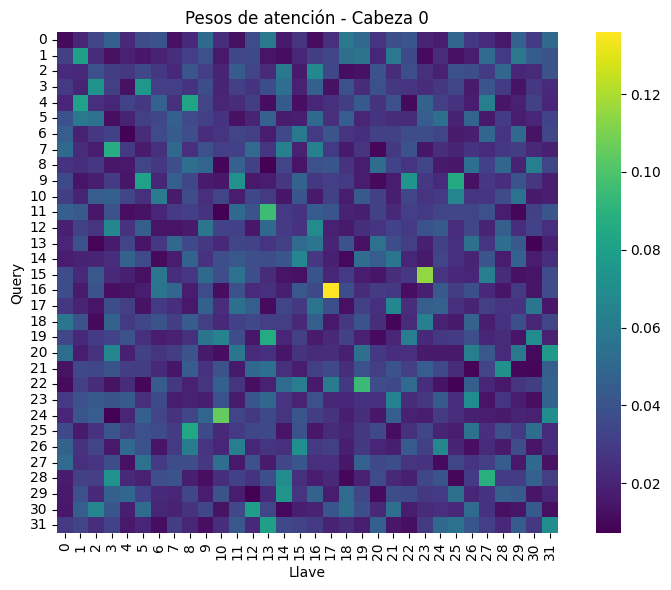

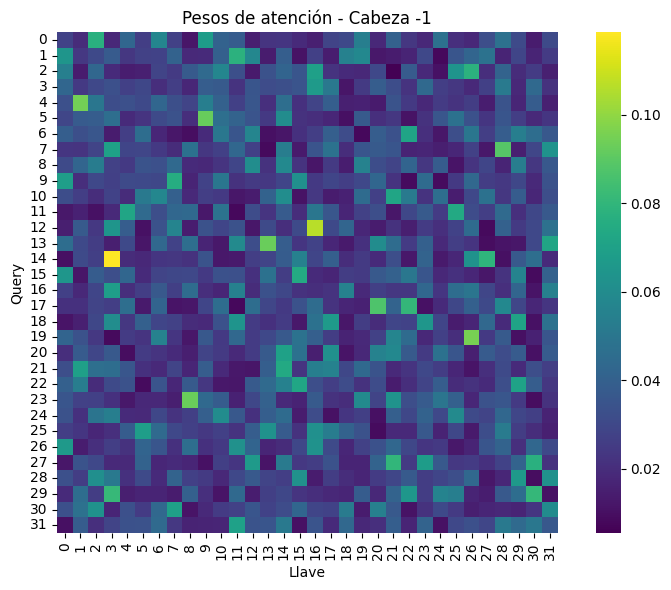

In [9]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(model, input_data):
    """
    Extrae y visualiza los valroes de atención de la capa a partir de un input.
    
    model-> red_cabrona()
    input_data-> Tensor de size(): [seq_len, batch, d_model]
    """
    model.eval()
    
    with torch.no_grad():
        attn_weights = []
        
        def hook_fn(module, input, output):
            pass

        attn_output, attn_weights = model.enc_layer.self_attn(
            input_data, 
            input_data, 
            input_data,
            need_weights=True,
            average_attn_weights=False  # Get all heads
        )
        
        return attn_weights

def plot_attention_heads(attn_weights, head_idx=0):
    """
    Dados los valores de atención extraídos previamente, esta función hace la graficación explícita.
    
    attn_weights: Tensor de size() [batch, num_heads, seq_len, seq_len]
    head_idx: La cabeza de atención que queremos analizar.
    """
    attn = attn_weights[0, head_idx].cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, cmap='viridis', annot=False, square=True)
    plt.xlabel('Llave')
    plt.ylabel('Query')
    plt.title(f'Pesos de atención - Cabeza {head_idx}')
    plt.tight_layout()
    plt.show()

input_data = torch.randn(32, 1, 16000)  # [seq_len, batch, d_model]
attn_weights = visualize_attention(red_cabrona, input_data)
plot_attention_heads(attn_weights, head_idx=0)
plot_attention_heads(attn_weights, head_idx=-1)

In [10]:
%%time
# Ya entrena
lr = 0.003
epochs = 3
loss_fun = nn.CrossEntropyLoss()
optim = th.optim.Adam(red_cabrona.parameters(), lr = lr)

for _ in range(epochs):
    print("------Epoch: {}------".format(_+1))
    train_loop(dl, red_cabrona, loss_fun, optim)
print('Acabamos papito.')

------Epoch: 1------
Loss: -0.0. [32/105829]
Loss: -0.0. [3232/105829]
Loss: -0.0. [6432/105829]
Loss: -0.0. [9632/105829]
Loss: -0.0. [12832/105829]
Loss: -0.0. [16032/105829]
Loss: -0.0. [19232/105829]
Loss: -0.0. [22432/105829]
Loss: -0.0. [25632/105829]
Loss: -0.0. [28832/105829]
Loss: -0.0. [32032/105829]
Loss: -0.0. [35232/105829]
Loss: -0.0. [38432/105829]
Loss: -0.0. [41632/105829]
Loss: -0.0. [44832/105829]
Loss: -0.0. [48032/105829]
Loss: -0.0. [51232/105829]
Loss: -0.0. [54432/105829]
Loss: -0.0. [57632/105829]
Loss: -0.0. [60832/105829]
Loss: -0.0. [64032/105829]
Loss: -0.0. [67232/105829]
Loss: -0.0. [70432/105829]
Loss: -0.0. [73632/105829]
Loss: -0.0. [76832/105829]
Loss: -0.0. [80032/105829]
Loss: -0.0. [83232/105829]
Loss: -0.0. [86432/105829]
Loss: -0.0. [89632/105829]
Loss: -0.0. [92832/105829]
Loss: -0.0. [96032/105829]
Loss: -0.0. [99232/105829]
Loss: -0.0. [102432/105829]
Loss: -0.0. [105632/105829]
------Epoch: 2------
Loss: -0.0. [32/105829]
Loss: -0.0. [3232/10

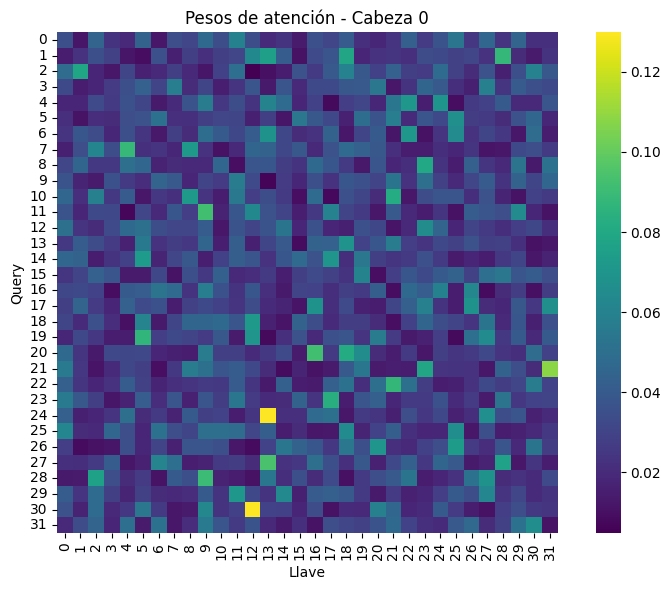

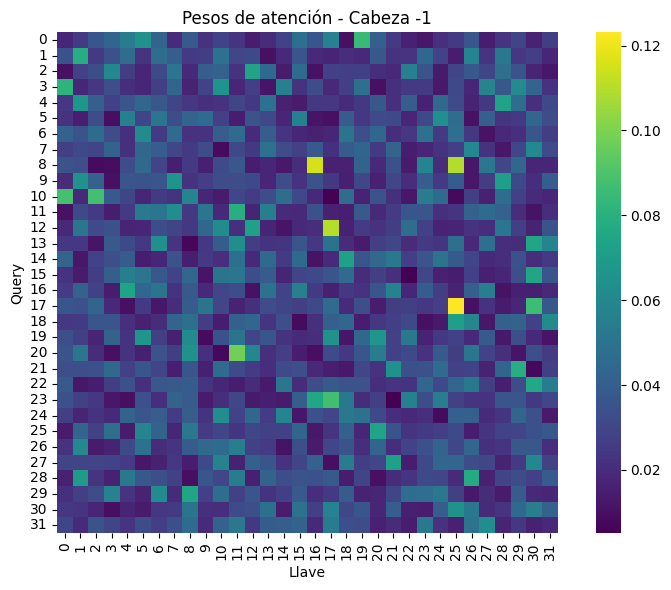

In [11]:
input_data = torch.randn(32, 1, 16000)  # [seq_len, batch, d_model]
attn_weights = visualize_attention(red_cabrona, input_data)
plot_attention_heads(attn_weights, head_idx=0)
plot_attention_heads(attn_weights, head_idx=-1)

# Ej3: Generación de rostros

In [ ]:
from math import sqrt, floor, ceil

import numpy as np
import matplotlib.pyplot as plt

import torch as th
from torch import nn
from torch.utils.data import DataLoader, Dataset

import torchvision as tv
import torchvision.transforms as T

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

N_MUESTRAS_IMG = 32      # para visualizar
FREQ_GENVIS = 2          # cada cuántas épocas guardar imágenes generadas
N_EPOCAS = 10            # AJUSTA ESTO (empieza con algo pequeño para probar)

IMG_SIZE = 64            # puede ser 32 o 64; el DCGAN que usamos asume 64
N_CANALES = 256
T_LOTE = 64
T_EMB = 100
LR = 0.0002
BETA1 = 0.5

DC = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
print("Dispositivo:", DC)

np.random.seed(42)
th.manual_seed(42)

In [ ]:
data = load_dataset("HuggingFaceM4/FairFace", "0.25")
print(data)

In [ ]:
class HF_FairFace(Dataset):
    """
    Envuelve el split de HuggingFace en un Dataset de PyTorch.

    Cada elemento tiene:
      - image: tensor normalizado en [-1, 1]
      - age:   entero con el grupo etario [0..7]
    """
    def __init__(self, hf_split, transform=None):
        self.data = hf_split
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item["image"]   # PIL.Image
        label = item["age"]     # entero [0..7]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

tr_gan = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)),
])

val_tr_gan = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)),
])

In [ ]:
# Definimos los grupos de edad
AGE_GROUPS = {
    0: "0-2",
    1: "3-9",
    2: "10-19",
    3: "20-29",
    4: "30-39",
    5: "40-49",
    6: "50-59",
    7: "60+",
}

YOUNG_LABELS = {2, 3, 4}     # jóvenes
OLD_LABELS   = {6, 7}        # adultos mayores

print("Etiquetas jóvenes:", YOUNG_LABELS)
print("Etiquetas adulto mayor:", OLD_LABELS)

# Tomamos solo una fracción del dataset completo para acelerar
n_total = len(data["train"])
frac = 0.10
n_subset = int(frac * n_total)

print(f"Total original: {n_total}")
print(f"Usando {frac*100:.0f}% → {n_subset} ejemplos")

idxs = np.arange(n_total)

# Etiquetas completas del split train
labels_full = np.array([data["train"][int(i)]["age"] for i in idxs])

# Elegimos un subconjunto estratificado para mantener distribución de edades
idxs_sub, _, _, _ = train_test_split(
    idxs,
    labels_full,
    train_size=n_subset,
    stratify=labels_full,
    random_state=42,
)

# Construimos un "sub-split" de HuggingFace usando select
train_hf_sub = data["train"].select(idxs_sub)

# Ahora dividimos este subconjunto en train/val
labels_sub = np.array([train_hf_sub[int(i)]["age"] for i in range(len(train_hf_sub))])
idxs_train, idxs_val, _, _ = train_test_split(
    np.arange(len(train_hf_sub)),
    labels_sub,
    test_size=0.2,
    stratify=labels_sub,
    random_state=42,
)

train_hf = train_hf_sub.select(idxs_train)
val_hf   = train_hf_sub.select(idxs_val)

print("Tamaño train_hf:", len(train_hf))
print("Tamaño val_hf:", len(val_hf))

# Creamos datasets de PyTorch
train_ds_full = HF_FairFace(train_hf, transform=tr_gan)
val_ds_full   = HF_FairFace(val_hf,   transform=val_tr_gan)

# Filtrar por dominio (joven / adulto mayor)
def filtra_por_edades(dataset, allowed_labels):
    idxs = [i for i in range(len(dataset)) if dataset[i][1] in allowed_labels]
    return th.utils.data.Subset(dataset, idxs)

train_ds_young = filtra_por_edades(train_ds_full, YOUNG_LABELS)
train_ds_old   = filtra_por_edades(train_ds_full, OLD_LABELS)

val_ds_young   = filtra_por_edades(val_ds_full, YOUNG_LABELS)
val_ds_old     = filtra_por_edades(val_ds_full, OLD_LABELS)

print("Tamaños por dominio:")
print("  Train jóvenes:", len(train_ds_young))
print("  Train adultos mayores:", len(train_ds_old))
print("  Val jóvenes:", len(val_ds_young))
print("  Val adultos mayores:", len(val_ds_old))

# DataLoaders para cada dominio
train_dl_young = DataLoader(
    train_ds_young,
    batch_size=T_LOTE,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True,
)

train_dl_old = DataLoader(
    train_ds_old,
    batch_size=T_LOTE,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True,
)

val_dl_young = DataLoader(
    val_ds_young,
    batch_size=T_LOTE,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    pin_memory=True,
)

val_dl_old = DataLoader(
    val_ds_old,
    batch_size=T_LOTE,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    pin_memory=True,
)

In [ ]:
def muestra_imagenes(imgs, titulos=None):
    t_muestra = imgs.shape[0]
    n_filas = floor(sqrt(t_muestra))
    n_cols = ceil(sqrt(t_muestra))

    fig, ax = plt.subplots(nrows=n_filas, ncols=n_cols, figsize=(n_cols * 2, n_filas * 2))
    ax = np.array(ax).reshape(n_filas, n_cols)

    for i in range(n_filas):
        for j in range(n_cols):
            idx = i * n_cols + j
            if idx >= t_muestra:
                ax[i, j].axis('off')
                continue
            img = imgs[idx]
            # desnormalizar de [-1,1] a [0,1]
            img = (img.permute(1, 2, 0).numpy() * 0.5) + 0.5
            img = np.clip(img, 0, 1)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            if titulos is not None and idx < len(titulos):
                ax[i, j].set_title(titulos[idx], fontsize=8)

    plt.tight_layout()
    plt.show()


# Obtener un batch de jóvenes
batch_young, labels_y = next(iter(train_dl_young))
batch_old, labels_o   = next(iter(train_dl_old))

print("Batch jóvenes shape:", batch_young.shape)
print("Batch adultos mayores shape:", batch_old.shape)

muestra_imagenes(batch_young[:N_MUESTRAS_IMG])
muestra_imagenes(batch_old[:N_MUESTRAS_IMG])

In [ ]:
class Generador(nn.Module):
    def __init__(self, t_emb, nf=1024):
        super(Generador, self).__init__()

        self.nf = nf
        self.t_emb = t_emb

        self.proj = nn.Linear(t_emb, 4 * 4 * nf, bias=False)
        self.bn_proj = nn.BatchNorm1d(4 * 4 * nf)

        self.bloque1 = nn.Sequential(
            nn.ConvTranspose2d(nf, nf // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf // 2),
        )
        self.bloque2 = nn.Sequential(
            nn.ConvTranspose2d(nf // 2, nf // 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf // 4),
        )
        self.bloque3 = nn.Sequential(
            nn.ConvTranspose2d(nf // 4, nf // 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf // 8),
        )
        self.output = nn.ConvTranspose2d(nf // 8, 3, 4, 2, 1, bias=False)

    def forward(self, x):
        x = self.proj(x)
        x = nn.functional.relu(self.bn_proj(x))
        x = x.reshape(-1, self.nf, 4, 4)

        x = nn.functional.relu(self.bloque1(x))
        x = nn.functional.relu(self.bloque2(x))
        x = nn.functional.relu(self.bloque3(x))
        x = nn.functional.tanh(self.output(x))

        return x


class Discriminador(nn.Module):
    def __init__(self, nf=1024):
        super(Discriminador, self).__init__()

        self.conv1 = nn.Conv2d(3, nf // 8, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(nf // 8)
        self.conv2 = nn.Conv2d(nf // 8, nf // 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nf // 4)
        self.conv3 = nn.Conv2d(nf // 4, nf // 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nf // 2)
        self.conv4 = nn.Conv2d(nf // 2, nf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nf)

        self.output = nn.Linear(nf * 4 * 4, 1, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.leaky_relu(x, negative_slope=0.2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.leaky_relu(x, negative_slope=0.2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.functional.leaky_relu(x, negative_slope=0.2)

        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.functional.leaky_relu(x, negative_slope=0.2)

        x = self.output(x.flatten(start_dim=1))
        return x


def genera_imagenes(gen, n_imagenes, t_emb, disp):
    gen.eval()
    with th.no_grad():
        Z = th.rand((n_imagenes, t_emb), device=disp)
        X_gen = gen(Z)
        X_gen = X_gen.permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5
        return X_gen


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class PerdidaGAN:
    def __init__(self):
        self.ecc = nn.BCEWithLogitsLoss()

    def gen(self, falsas):
        return self.ecc(falsas, th.ones_like(falsas))

    def dis(self, reales, falsas):
        perdida_real = self.ecc(reales, th.ones_like(reales))
        perdida_falsa = self.ecc(falsas, th.zeros_like(falsas))
        return perdida_real + perdida_falsa


def registra_info_tboard(writer, epoca, hist):
    for (m, v) in hist.items():
        writer.add_scalar(m, v[epoca], epoca)

In [ ]:
def paso_ent(gen, dis, fp, opt_gen, opt_dis, X):
    # X: batch de imágenes (tensor) en dispositivo apropiado
    opt_dis.zero_grad()
    opt_gen.zero_grad()

    t_lote = X.size(0)
    Z = th.rand((t_lote, T_EMB), device=X.device)

    # generamos imágenes falsas
    X_gen = gen(Z)

    # pasamos por el discriminador
    reales = dis(X)
    falsas = dis(X_gen.detach())

    # pérdida del discriminador
    perdida_dis = fp.dis(reales, falsas)
    perdida_dis.backward()
    opt_dis.step()

    # pérdida del generador
    falsas = dis(X_gen)
    perdida_gen = fp.gen(falsas)
    perdida_gen.backward()
    opt_gen.step()

    with th.no_grad():
        perdida_gen_paso = perdida_gen.cpu().item()
        perdida_dis_paso = perdida_dis.cpu().item()

    return perdida_gen_paso, perdida_dis_paso


def entrena(gen,
            dis,
            fp,
            opt_gen,
            opt_dis,
            dl,
            n_epocas,
            disp,
            freq_vis=5,
            tbdir='runs/'):
    hist = {
        'perdida_gen': np.zeros(n_epocas),
        'perdida_dis': np.zeros(n_epocas),
    }

    lst_img_gen = []

    writer = SummaryWriter(tbdir)

    n_batches = len(dl)

    for e in range(n_epocas):
        gen.train()
        dis.train()

        sum_loss_g = 0.0
        sum_loss_d = 0.0

        for X, _ in dl:  # ignoramos etiqueta de edad
            X = X.to(disp)

            perdida_g, perdida_d = paso_ent(gen, dis, fp,
                                            opt_gen, opt_dis, X)

            sum_loss_g += perdida_g
            sum_loss_d += perdida_d

        hist['perdida_gen'][e] = sum_loss_g / n_batches
        hist['perdida_dis'][e] = sum_loss_d / n_batches

        registra_info_tboard(writer, e, hist)

        print(f'Época {e+1}/{n_epocas}: '
              f'Pérdida G = {hist['perdida_gen'][e]:.3f}, '
              f'Pérdida D = {hist['perdida_dis'][e]:.3f}')

        if e % freq_vis == 0 or e == n_epocas - 1:
            X_gen = genera_imagenes(gen, N_MUESTRAS_IMG, T_EMB, disp)
            lst_img_gen.append(X_gen)

    writer.close()
    return gen, dis, hist, lst_img_gen

In [ ]:
gen_young = Generador(T_EMB, N_CANALES).apply(weights_init).to(DC)
dis_young = Discriminador(N_CANALES).apply(weights_init).to(DC)

opt_gen_y = th.optim.Adam(gen_young.parameters(), lr=LR, betas=(BETA1, 0.999))
opt_dis_y = th.optim.Adam(dis_young.parameters(), lr=LR, betas=(BETA1, 0.999))

fp = PerdidaGAN()

gen_young, dis_young, hist_y, imgs_y = entrena(
    gen_young,
    dis_young,
    fp,
    opt_gen_y,
    opt_dis_y,
    train_dl_young,
    N_EPOCAS,
    DC,
    FREQ_GENVIS,
    tbdir='./runs/gan_young',
)

In [ ]:
gen_old = Generador(T_EMB, N_CANALES).apply(weights_init).to(DC)
dis_old = Discriminador(N_CANALES).apply(weights_init).to(DC)

opt_gen_o = th.optim.Adam(gen_old.parameters(), lr=LR, betas=(BETA1, 0.999))
opt_dis_o = th.optim.Adam(dis_old.parameters(), lr=LR, betas=(BETA1, 0.999))

gen_old, dis_old, hist_o, imgs_o = entrena(
    gen_old,
    dis_old,
    fp,
    opt_gen_o,
    opt_dis_o,
    train_dl_old,
    N_EPOCAS,
    DC,
    FREQ_GENVIS,
    tbdir='./runs/gan_old',
)

In [ ]:
def invierte_latente(gen,
                     img,
                     n_iters=300,
                     lr_z=0.05,
                     lambda_reg=1e-3):
    """
    Dados:
      - gen: generador entrenado (congelado)
      - img: tensor (3, H, W), normalizado [-1,1] en DC
    Busca un z tal que G(z) ~ img minimizando MSE + regularización de z.
    """
    gen.eval()
    for p in gen.parameters():
        p.requires_grad_(False)

    img = img.unsqueeze(0).to(DC)   # (1,3,H,W)

    # z inicial aleatorio ~ U(0,1)
    z = th.rand((1, T_EMB), device=DC, requires_grad=True)

    opt_z = th.optim.Adam([z], lr=lr_z)

    mse = nn.MSELoss()

    for it in range(n_iters):
        opt_z.zero_grad()
        x_rec = gen(z)
        loss_rec = mse(x_rec, img)
        loss_reg = lambda_reg * (z ** 2).mean()
        loss = loss_rec + loss_reg
        loss.backward()
        opt_z.step()

    with th.no_grad():
        x_rec = gen(z).detach()
    return z.detach(), x_rec.squeeze(0).cpu()

In [ ]:
def traduce_edad(img,
                 gen_src,
                 gen_tgt,
                 n_iters=300,
                 lr_z=0.05,
                 lambda_reg=1e-3):
    """
    img: tensor (3,H,W) en [-1,1]
    gen_src: generador del dominio de la imagen (joven o viejo)
    gen_tgt: generador del dominio objetivo

    Devuelve:
      - rec_src: reconstrucción en dominio fuente
      - img_tgt: imagen traducida al dominio objetivo
    """
    z_opt, rec_src = invierte_latente(
        gen_src, img,
        n_iters=n_iters,
        lr_z=lr_z,
        lambda_reg=lambda_reg,
    )

    gen_tgt.eval()
    for p in gen_tgt.parameters():
        p.requires_grad_(False)

    with th.no_grad():
        img_tgt = gen_tgt(z_opt).squeeze(0).cpu()

    return rec_src, img_tgt

In [ ]:
def desnormaliza_para_plot(img_t):
    """
    img_t: tensor (3,H,W) en [-1,1]
    """
    img = img_t.permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    return img

# Tomamos algunas imágenes jóvenes de validación
ejemplos_young = []
for X, _ in val_dl_young:
    ejemplos_young.append(X)
    if len(ejemplos_young) * X.size(0) >= 4:
        break
ejemplos_young = th.cat(ejemplos_young, dim=0)[:4]

# Tomamos algunas imágenes de adultos mayores de validación
ejemplos_old = []
for X, _ in val_dl_old:
    ejemplos_old.append(X)
    if len(ejemplos_old) * X.size(0) >= 4:
        break
ejemplos_old = th.cat(ejemplos_old, dim=0)[:4]

# --------- joven → adulto mayor ----------
fig, axs = plt.subplots(4, 3, figsize=(9, 12))

for i in range(4):
    img_y = ejemplos_young[i]

    rec_y, y_to_old = traduce_edad(
        img_y,
        gen_src=gen_young,
        gen_tgt=gen_old,
        n_iters=200,    # puedes subir este número si tienes tiempo
        lr_z=0.05,
    )

    axs[i, 0].imshow(desnormaliza_para_plot(img_y))
    axs[i, 0].set_title("Joven\n(original)")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(desnormaliza_para_plot(rec_y))
    axs[i, 1].set_title("Joven\n(reconstruida)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(desnormaliza_para_plot(y_to_old))
    axs[i, 2].set_title("Adulto mayor\n(traducida)")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

# --------- adulto mayor → joven ----------
fig, axs = plt.subplots(4, 3, figsize=(9, 12))

for i in range(4):
    img_o = ejemplos_old[i]

    rec_o, o_to_y = traduce_edad(
        img_o,
        gen_src=gen_old,
        gen_tgt=gen_young,
        n_iters=200,
        lr_z=0.05,
    )

    axs[i, 0].imshow(desnormaliza_para_plot(img_o))
    axs[i, 0].set_title("Adulto mayor\n(original)")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(desnormaliza_para_plot(rec_o))
    axs[i, 1].set_title("Adulto mayor\n(reconstruida)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(desnormaliza_para_plot(o_to_y))
    axs[i, 2].set_title("Joven\n(traducida)")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Extra: Generación de texto

La base del código corresponde a la implementación realizada en el notebook oficial del curso [(Github de Gibrán)](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2026-1/notebooks/4a_gpt.ipynb), que a su vez está basado en el modelo NanoGPT. La importación de datos, al ser de un conjunto de datos distinto, es realizada de manera personal.

In [ ]:
import os
import requests

import copy
from itertools import islice
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch as th
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from torchmetrics.text import Perplexity

from torch.utils.tensorboard import SummaryWriter

LR = 1e-3 # tasa de aprendizaje
WD = 1e-4 # weight decay
D_EMBED = 64 # tamaño de los embeddings
D_RDP = 4 * D_EMBED # tamaño de capa oculta de red hacia adelante por posición
N_CABEZAS = 4  # número de cabezas de autoatención
N_CAPAS = 4 # número de bloques Transformers
P_DROPOUT = 0.2 # Probabilidad de dropout

T_CONTEXTO = 32 # tamaño del contexto
MAXSEC = 2000 # tamaño máximo de secuencia ←en generación

T_LOTE = 128
N_EPOCAS = 30
LOGDIR = './logs/'
DC = 'cuda:0' if th.cuda.is_available() else 'cpu'

th.manual_seed(22)
np.random.seed(22)

## Extra.1: Importación de datos

In [ ]:
from collections import Counter

class SpanishDS(Dataset):
    """
    Similar a la clase TinyShakespeare, pero ajustada al conjunto de datos que necesitamos.
    """
    def __init__(self, context_size, path):
        self.path = # AQUÍ VA LA RUTA LOCAL AL DATASET
        self.context_size = context_size
        with open(self.path, 'r', encoding = 'utf-8') as f:
            self.text = f.read()

        self.voc = Counter([c for c in self.text])
        self.voc_size = len(self.voc)

        self.i2c = {i:c for i,(c,f) in enumerate(self.voc.most_common())}
        self.c2i = {c:i for i,(c,f) in enumerate(self.voc.most_common())}